# Sampling In Continuous Graphical Models
As we know inference is asking conditional probability questions to the models, the exact solution of these problems quickly becomes intractable. Sampling algorithms can be used to get approximate inference results by generating a large
number of coherent samples that converge to original distribution. In this notebook we take a look at some of the 
sampling algorithms that can be used to sample from continuous case models.

1. Hamiltonian Monte Carlo
2. No-U-Turn Sample

## Hamiltonian Monte Carlo
Hamiltonian Monte Carlo (HMC) is a Markov Chain Monte Carlo (MCMC) that proposes future states in Markov Chain using
Hamiltonian Dynamics. Before understanding the HMC algorithm lets first understand Hamiltonian Dynamics.

### Hamiltonian Dynamics
Hamiltonian dynamics are used to describe how objects move throughout a
system. Hamiltonian dynamics is defined in terms of object location $x$
and its momentum $p$ (equivalent to object's mass times velocity) at some
time $t$. For each location of object there is an associated potential
energy $U(x)$ and with momentum there is associated 
kinetic energy $K(p)$. The total energy of system is constant and is called as Hamiltonian 
$H(x, p)$, defined as the sum of potential energy and kinetic energy:

$$ H(x, p) = U(x) + K(p) $$

The partial derivatives of the Hamiltonian determines how position $x$ and
momentum $p$ change over time $t$, according to Hamiltonian's equations:

$$ \frac{dx_i}{dt} = \frac{\partial H}{\partial p_i} = \frac{\partial K(p)}{\partial p_i}$$

$$ \frac{dp_i}{dt} = -\frac{\partial H}{\partial x_i} = -\frac{\partial U(x)}{\partial x_i}$$

The above equations operates on a *d-dimensional position vector $x$* and
a *d-dimensional momentum vector $p$*, for $i = 1, 2, \cdots, d$.

Thus, if we can evaluate $\frac{\partial U(x)}{\partial x_i}$ and 
$\frac{\partial K(p)}{\partial p_i}$ and have a set of initial conditions i.e
an initial position and initial momentum at time $t_0$, then we can predict
the location and momentum of object at any future time $t = t_0 + T$ by
simulating dynamics for a time duration $T$.
### Discretizing Hamiltonian's Equations

The Hamiltonian's equations describes an object's motion in regard to time,
which is a continuous variable. For simulating dynamics on a computer,
Hamiltonian's equations must be numerically approximated by discretizing time.
This is done by splitting the time interval $T$ into small intervals of size
$\epsilon$.

#### Euler's Method
For Hamiltonian's equations, this method performs the following steps, for
each component of position and momentum (indexed by $i=1, ...,d$)

$$ p_i(t + \epsilon) = p_i(t) + \epsilon \frac{dp_i}{dt}(t) = p_i(t) - \epsilon \frac{\partial U}{\partial x_i(t)} $$

$$ x_i(t + \epsilon) = x_i(t) + \epsilon \frac{dx_i}{dt} = x_i(t) + \epsilon \frac{\partial K}{\partial p_i(t)} $$

Even better results can be obtained if we use updated value of momentum
in later equation

$$ x_i(t + \epsilon) = x_i(t) + \epsilon \frac{\partial K}{\partial p_i(t + \epsilon)} $$

This method is called as **Modified Euler's method**.

#### Leapfrog Method
Unlike Euler's method where we take full steps for updating position and
momentum in leapfrog method we take half steps to update momentum value.

$$ p_i(t + \epsilon / 2) = p_i(t) - (\epsilon / 2) \frac{\partial U}{\partial x_i(t)} $$

$$x_i(t + \epsilon) = x_i(t) + \epsilon \frac{\partial K}{\partial p_i(t + \epsilon /2)}  $$

$$ p_i(t + \epsilon) = p_i(t) - (\epsilon / 2) \frac{\partial U}{\partial x_i(t + \epsilon)} $$

Leapfrog method yields even better result than Modified Euler Method.

#### Example: Simulating Hamiltonian dynamics of a simple pendulum

Imagine a bob of mass $m = 1$ attached to a string of length $l=1.5$
whose one end is fixed at point $(x=0, y=0)$.
The equilibrium position of the pendulum is at $x = 0$. Now keeping string
stretched we move it some distance horizontally say $x_0$. The corresponding
change in potential energy is given by

$ U(h) = mg\Delta h $, where $\Delta h$ is change in height and $g$ is gravity of earth.

Using simple trigonometry one can derive relationship between $x$ and 
$\Delta h$.

$$ U(x) = mgl(1 - cos(sin^{-1}(x/l)))$$

Kinetic energy of bob can be written in terms of momentum as

$$ K(v) = \frac{mv^2}{2} = \frac{(mv)^2}{2m} = \frac{p^2}{2m} = K(p)$$

Further, partial derivatives of potential and kinetic energy can be written as:

$$ \frac{\partial U}{\partial x} = \frac{mglx}{\sqrt{l^2 - x^2}}$$

and

$$ \frac{\partial K}{\partial p} = \frac{p}{m} $$

Here is a animation that uses these equations to simulate the dynamics of simple pendulum
<img src="../images/simple_pendulum.gif" alt="Drawing" style="width: 700px;"/>
The sub-plot in the right upper half of the output demonstrates the energies. The
red portion of first bar plot represents potential energy and black represents
kinetic energy. The second bar plot represents the Hamiltonian. The lower right sub-plot shows the phase space
showing how momentum and position are varying. We can see that phase space
maps out an ellipse without deviating from its path. In case of Euler
method the particle doesn't fully trace a ellipse instead diverges slowly 
towards infinity. One can clearly see that value of position and momentum are not completely
random, but takes a deterministic circular kind of trajectory.
If we use Leapfrog method to propose future states than we can avoid
random-walk behavior which we saw in Metropolis-Hastings algorithm. This is the main reason for good performance
of HMC algorithm.

### Hamiltonian and Probability: Canonical Distributions

Now having a bit of understanding what is Hamiltonian and how we can simulate
Hamiltonian dynamics, we now need to understand how we can use these
Hamiltonian dynamics for MCMC. We need to develop some relation between
probability distribution and Hamiltonian so that we can use Hamiltonian
dynamics to explore the distribution. To relate $H(x, p)$ to target
distribution $P(x)$ we use a concept from statistical mechanics known as
the canonical distribution. For any energy function $E(q)$, defined over a set of variables $q$, we
can find corresponding $P(q)$

$$ P(q) = \frac{1}{Z} exp \left( \frac{-E(q)}{T} \right) $$

, where $Z$ is normalizing constant called Partition function  and $T$ is
temperature of system. For our use case we will consider $T=1$.

Since, the Hamiltonian is an energy function for the joint state of "position",
$x$ and "momentum", $p$, so we can define a joint distribution for them
as follows:

$$ P(x, p) = \frac{e^{-H(x, p)}}{Z} $$

Since $H(x, p) = U(x) + K(p)$, we can write above equation as

$$P(x, p) = \frac{e^{-U(x)-K(p)}}{z}$$

$$P(x, p) = \frac{e^{-U(x)}e^{-K(p)}}{Z}$$

Furthermore we can associate probability distribution with each of the
potential and kinetic energy ($P(x)$ with potential energy and $P(p)$,
with kinetic energy). Thus, we can write above equation as:

$$P(x, p) = \frac{P(x)P(p)}{Z'} $$

,where $Z'$ is new normalizing constant. Since joint distribution factorizes
over $x$ and $p$, we can conclude that $P(x)$ and $P(p)$ are independent.
Because of this independence we can choose any distribution
from which we want to sample the momentum variable. A common choice is to use
a zero mean and unit variance Normal distribution $N(0, I)$ 
The target distribution of interest $P(x)$ from which we actually want to
sample from is associated with potential energy.

$$U(x) = - log (P(x))$$

Thus, if we can calculate $\frac{\partial log(P(x))}{\partial x_i}$, then
we are in business and we can use Hamiltonian dynamics to generate samples.

### Hamiltonian Monte Carlo Algorithm
Given initial state $x_0$, stepsize $\epsilon$, number of steps $L$, 
log density function $U$, number of samples to be drawn $M$, we can write HMC algorithm as:

- set $m = 0 $
- repeat until $m = M$

    1. set  $m \leftarrow m + 1$

    2. Sample new initial momentum $p_0$ ~ $N(0, I)$
    
    3. Set $x_m \leftarrow x_{m-1}, x' \leftarrow x_{m-1}, p' \leftarrow p_0$

    4. repeat for $L$ steps

        - Set $x', p' \leftarrow Leapfrog(x', p', \epsilon)$

    5. Calculate acceptance probability $\alpha = min \left(1, \frac{exp( U(x') - (p'.p')/2 )}{exp( U(x_{m-1}) - (p_0.p_0)/2 )} \right)$

    6. Draw a random number u ~ Uniform(0, 1)
 
    7. if $u \leq \alpha$ then  $x_m \leftarrow x', p_m \leftarrow -p'$

$Leapfrog$ is a function that runs a single iteration of Leapfrog method.

In practice sometimes instead of explicitly giving number of steps $L$, 
we use **trajectory length** which is product of number of steps $L$,
and stepsize $\epsilon$.

### Hamiltonian Monte Carlo in pgmpy
In pgmpy one can use Hamiltonian Monte Carlo algorithm by importing HamiltonianMC from pgmpy.inference.continuous 

In [9]:
from pgmpy.inference.continuous import HamiltonianMC as HMC

Lets use the HamiltonianMC implementation and draw some samples from a multivariate disrtibution $ P(x) = N(\mu, \Sigma)$, where
$$
\mu = [0, 0], \qquad
\Sigma = \left[
    \begin{array}{cc}
    1 & 0.97 \\
    0.97 & 1
    \end{array}
    \right]
$$

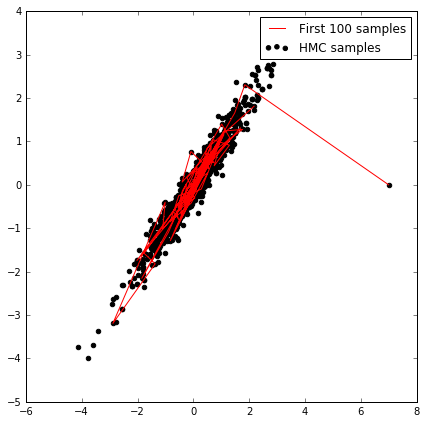

In [17]:
%matplotlib inline
from pgmpy.factors import JointGaussianDistribution
from pgmpy.inference.continuous import LeapFrog, GradLogPDFGaussian
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(77777)
# Defining a multivariate distribution model
mean = np.array([0, 0])
covariance = np.array([[1, 0.97], [0.97, 1]])
model = JointGaussianDistribution(['x', 'y'], mean, covariance)

# Creating a HMC sampling instance
sampler = HMC(model=model, grad_log_pdf=GradLogPDFGaussian, simulate_dynamics=LeapFrog)
# Drawing samples
samples = sampler.sample(initial_pos=np.array([7, 0]), num_samples = 1000,
                         trajectory_length=10, stepsize=0.25)
plt.figure(figsize=(7, 7)); plt.hold(True)
plt.scatter(samples['x'], samples['y'], label='HMC samples', color='k')
plt.plot(samples['x'][0:100], samples['y'][0:100], 'r-', label='First 100 samples')
plt.legend(); plt.hold(False)
plt.show()

One, can change the values of parameters `stepsize` and `trajectory_length` and see the convergence towards target distribution. For example set the value of `stepsize = 0.5` and let rest parameters have the same value and see the output. With this you might get a feel that performance of HMC critically depends upon choice of these parameters.

The `stepsize` parameter for HamiltonianMC implementation is optional, but should be use only as starting point value.
One should hand-tune the model using this stepsize value for good performance.

### Hamiltonian Monte Carlo with dual averaging
In pgmpy we have implemented an another variant of HMC in which we adapt the stepsize during the course of sampling thus
completely eliminates the need of specifying `stepsize` (but still requires
`trajectory_length` to be specified by user). This variant of HMC is known as Hamiltonian Monte Carlo with dual averaging (HamiltonianMCda in pgmpy). One can also use Modified Euler to simulate dynamics instead of leapfrog, or even can plug-in one's own implementation for simulating dynamics using base class for it.

In [28]:
from pgmpy.inference.continuous import HamiltonianMCda as HMCda, ModifiedEuler
# Using modified euler instead of Leapfrog for simulating dynamics
sampler_da = HMCda(model, GradLogPDFGaussian, simulate_dynamics=ModifiedEuler)
# num_adapt is number of iteration to run adaptation of stepsize
samples = sampler_da.sample(initial_pos=np.array([7, 0]), num_adapt=10, num_samples=10, trajectory_length=10)
print(samples)
print("\nAcceptance rate:",sampler_da.acceptance_rate)

               x         y
0   7.000000e+00  0.000000
1  3.458460e-323  0.000000
2  3.458460e-323  0.000000
3   2.823863e+00  2.593248
4   6.472564e-01  0.981969
5   4.394445e-01  0.356047
6  -1.209309e+00 -1.275557
7  -1.209309e+00 -1.275557
8  -1.316306e+00 -1.780081
9  -1.552390e+00 -0.968519

Acceptance rate: 0.7


The values returned by HamiltonianMC and HamiltonianMCda depends upon the installation available in the working environment. In working env has a installation of pandas, it returns a pandas.DataFrame object otherwise it returns a
numpy.recarry (numpy recorded arrays).

Lets now use base class for simulating hamiltonian dynamics and write our own Modified Euler method

In [42]:
from pgmpy.inference.continuous import BaseSimulateHamiltonianDynamics

class ModifiedEulerMethod(BaseSimulateHamiltonianDynamics):
    def __init__(self, model, position, momentum, stepsize, grad_log_pdf, grad_log_position=None):

        BaseSimulateHamiltonianDynamics.__init__(self, model, position, momentum,
                                                 stepsize, grad_log_pdf, grad_log_position)

        self.new_position, self.new_momentum, self.new_grad_logp = self._get_proposed_values()

    def _get_proposed_values(self):
        new_momentum = self.momentum + self.stepsize * self.grad_log_position
        new_position = self.position + self.stepsize * new_momentum

        grad_log, _ = self.grad_log_pdf(new_position, self.model).get_gradient_log_pdf()

        return new_position, new_momentum, grad_log

hmc_sampler = HMC(model, GradLogPDFGaussian, simulate_dynamics=ModifiedEulerMethod)
samples = hmc_sampler.sample(initial_pos=np.array([0, 0]), num_samples=10, trajectory_length=10, stepsize=0.2)
print(samples)
print("Total accepted proposal:", hmc_sampler.accepted_proposals)

          x         y
0  0.000000  0.000000
1 -0.270298 -0.136220
2 -1.039499 -0.843548
3 -1.039499 -0.843548
4 -1.570932 -1.552578
5 -2.450890 -2.432799
6 -0.611937 -0.641865
7 -1.547999 -1.564384
8 -1.547999 -1.564384
9 -1.141980 -1.088134
Total accepted proposal: 8.0


## No-U-Turn Sampler
Both (HMC and HMCda) of these algorithms requires some hand-tuning from user,
which can be time consuming especially for high dimensional complex model.
No-U-Turn Sampler(NUTS) is an extension of HMC that eliminates the need to specify the
trajectory length but requires user to specify stepsize.

NUTS, removes the need of parameter number of steps by considering a metric
to evaluate whether we have ran Leapfrog algorithm for long enough, that
is when running the simulation for more steps would no longer increase
the distance between the proposal value of $x$ and initial value of
$x$

At high level, NUTS uses the leapfrog method to trace out a path forward
and backward in fictitious time, first running forwards or backwards
1 step, the forwards and backwards 2 steps, then forwards or backwards
4 steps etc. This doubling process builds a balanced binary tree whose
leaf nodes correspond to position-momentum states. The doubling process is
halted when the sub-trajectory from the leftmost to the rightmost nodes of
any balanced subtree of the overall binary tree starts to double back on
itself (i.e., the  fictional particle starts to make a "U-Turn"). At
this point NUTS stops the simulation and samples from among the set of
points computed during  the  simulation, taking are to preserve detailed
balance.

Lets use NUTS and draw some samples.

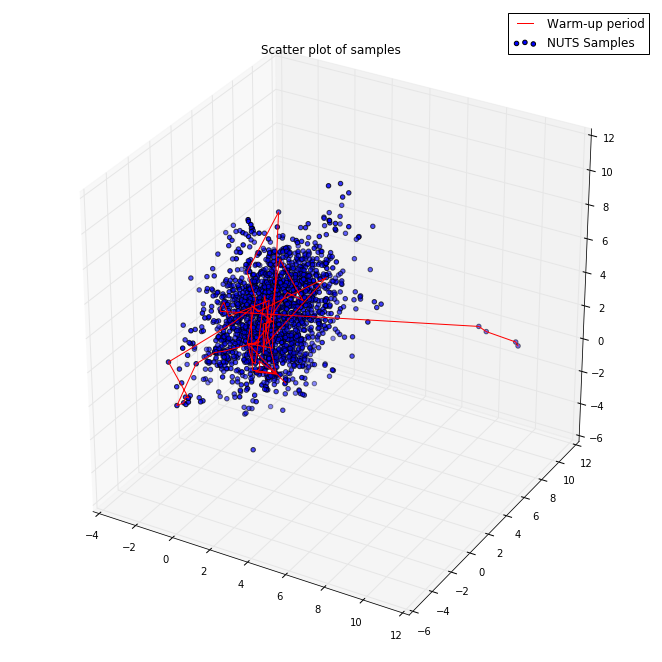

In [56]:
from pgmpy.inference.continuous import NoUTurnSampler as NUTS
mean = np.array([1, 2, 3])
covariance = np.array([[2, 0.4, 0.5], [0.4, 3, 0.6], [0.5, 0.6, 4]])
model = JointGaussianDistribution(['x', 'y', 'z'], mean, covariance)

# Creating sampling instance of NUTS
NUTS_sampler = NUTS(model=model, grad_log_pdf=GradLogPDFGaussian)
samples = NUTS_sampler.sample(initial_pos=[10, 10, 0], num_samples=2000, stepsize=0.25)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9, 9))
ax = Axes3D(fig)
plt.hold(True)
ax.scatter(samples['x'], samples['y'], samples['z'], label='NUTS Samples')
ax.plot(samples['x'][:50], samples['y'][:50], samples['z'][:50], 'r-', label='Warm-up period')
plt.legend()
plt.title("Scatter plot of samples")
plt.hold(False)
plt.show()

The **Warm-up period** a.k.a **Burn-in period** of Markov chain , is the amount of time it takes for the markov chain
to reach the target stationary distribution. The samples generated during this period of Markov chain are usually thrown away because they don't show the characteristics of distribution from which they are sampled.

Since it is difficult to visualize more than 3-Dimensions we generally use a trace-plot of Markov chain to determine this
warm-up period.

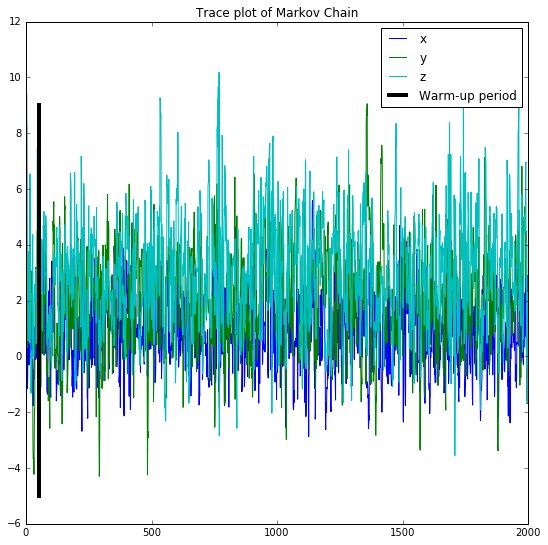

In [57]:
plt.figure(figsize=(9, 9))
plt.hold(True)
plt.plot(samples['x'],'b-', label='x')
plt.plot(samples['y'], 'g-', label='y')
plt.plot(samples['z'], 'c-', label='z')
plt.plot([50, 50], [-5, 9], 'k-', label='Warm-up period', linewidth=4)
plt.legend()
plt.title("Trace plot of Markov Chain")
plt.hold(False)
plt.show()

### No-U-Turn Sampler with dual averaging
Like HMCda in No-U-Turn sampler with dual averaging (NUTSda) we adapt the stepsize during the course of sampling thus completely eliminates the need of specifying `stepsize`. Thus we can use NUTSda without any hand tuning at all.

In [60]:
from pgmpy.inference.continuous import NoUTurnSamplerDA as NUTSda
NUTSda_sampler = NUTSda(model=model, grad_log_pdf=GradLogPDFGaussian)
samples = NUTSda_sampler.sample(initial_pos=[0.457420, 0.500307, 0.211056], num_adapt=10, num_samples=10)
print(samples)

          x         y         z
0  0.457420  0.500307  0.211056
1  0.457420  0.500307  0.211056
2  0.457420  0.500307  0.211056
3  3.137325  2.947369  5.291210
4  2.913086  2.756463  2.618393
5 -0.200069  0.891747  4.616066
6 -0.200069  0.891747  4.616066
7 -1.029595  3.759162  2.884154
8  1.860357 -1.645606  0.585393
9  0.712384  5.834463  5.428946


Apart from the `sample` method all the four algorithms (HMC, HMCda, NUTS, NUTSda) provides another method to sample from model named `generate_sample` method. `generate_sample` method returns a generator type object whose each iteration yields a sample. The sample returned is a simple numpy.array object. The arguments for `generate_sample` method and `sample` method for all algorithms are same

In [65]:
generate_samples = NUTSda_sampler.generate_sample(initial_pos=[0.4574, 0.503, 0.211], num_adapt=10, num_samples=10)
samples = np.array([sample for sample in generate_samples])
print(samples)

[[ 0.4341572   2.94426878  2.74490087]
 [ 0.4341572   2.94426878  2.74490087]
 [ 0.4341572   2.94426878  2.74490087]
 [ 0.30614826  3.14068736  0.18147477]
 [-0.36381465  0.14765421  3.42678832]
 [-0.36381465  0.14765421  3.42678832]
 [ 3.72030722  1.91907827  2.8786033 ]
 [ 0.29528482  3.34833866  4.40806666]
 [ 0.29528482  3.34833866  4.40806666]
 [ 1.21720707  1.52431019  3.39475386]]


## Support for coustom Models
One can also use HMC, HMCda, NUTS and NUTSda to sample from a user defined model, all one has to do is create class for finding log of probability density function and gradient log of probability density function using base class provided by pgmpy, and give this class as a parameter to `grad_log_pdf` argument in all of these algorithms (HMC[da], NUTS[da]).

In this example we will define our own logisitcs distribution and use NUTSda to sample from it.

The probability density of logistic distribution is given by:

$$ P(x; \mu, s) = \frac{e^{-\frac{x- \mu}{s}}}{s(1 + e^{-\frac{x - \mu}{s}})^2} $$

Thus the log of this probability density function (potential energy function) can be written as:

$$ log(P(x; \mu, s)) = -\frac{x - \mu}{s} - log(s) - 2 log(1 + e^{-\frac{x - \mu}{s}}) $$

And the gradient of potential energy :

$$ \frac{\partial log(P(x; \mu, s))}{\partial x} = - \frac{1}{s} + \frac{2e^{-\frac{x - \mu}{s}}}{s(1 + e^{-\frac{x - \mu}{s}})}$$

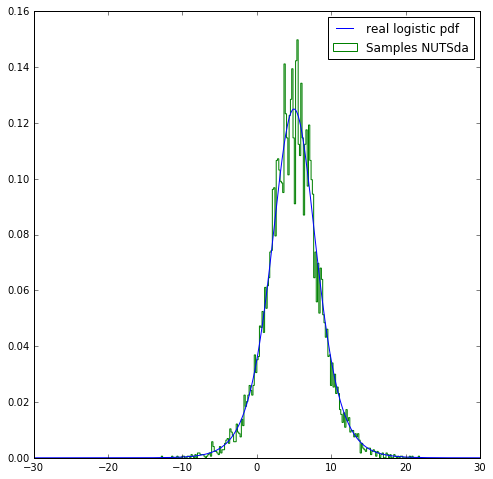

In [67]:
# Importing th base class structure for log and gradient log of probability density function
from pgmpy.inference.continuous import BaseGradLogPDF

# Base class for user defined continuous factor
from pgmpy.factors import ContinuousFactor


# Defining pdf of a Logistic distribution with mu = 5, s = 2
def logistic_pdf(x):
    power = - (x - 5.0) / 2.0
    return np.exp(power) / (2 * (1 + np.exp(power))**2)

# Calculating log of logistic pdf
def log_logistic(x):
    power = - (x - 5.0) / 2.0
    return power - np.log(2.0) - 2 * np.log(1 + np.exp(power))

# Calculating gradient log of logistic pdf
def grad_log_logistic(x):
    power = - (x - 5.0) / 2.0
    return - 0.5 - (2 / (1 + np.exp(power))) * np.exp(power) * (-0.5)

# Creating a logistic model
logistic_model = ContinuousFactor(['x'], logistic_pdf)

# Creating a class using base class for gradient log and log probability density function
class GradLogLogistic(BaseGradLogPDF):

    def __init__(self, variable_assignments, model):
        BaseGradLogPDF.__init__(self, variable_assignments, model)
        self.grad_log, self.log_pdf = self._get_gradient_log_pdf()

    def _get_gradient_log_pdf(self):
        return (grad_log_logistic(self.variable_assignments),
                log_logistic(self.variable_assignments))

# Generating samples using NUTS
sampler = NUTSda(model=logistic_model, grad_log_pdf=GradLogLogistic)
samples = sampler.sample(initial_pos=np.array([0.0]), num_adapt=10000,
                         num_samples=10000)

x = np.linspace(-30, 30, 10000)
y = [logistic_pdf(i) for i in x]
plt.figure(figsize=(8, 8))
plt.hold(1)
plt.plot(x, y, label='real logistic pdf')
plt.hist(samples.values, normed=True, histtype='step', bins=200, label='Samples NUTSda')
plt.legend()
plt.hold(0)
plt.show()